<a href="https://colab.research.google.com/github/davidwhogg/Sailing/blob/main/ipynb/sailing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anisotropic ram-pressure sailing model

## to-do items:
- do all the things in this notebook labeled HOGG.
- Make the optimal sail-setting and route-planning use lookup tables.
- (maybe) Use jax-numpy instead of numpy to get all derivatives?
- Solve the problem of setting the sail *best*, given the keel orientation.
- Solve the problem of setting both the sail and keel best if you want to go in a particular direction.
- Solve the problem of maximizing the magnitude of the velocity.
- Plot things in the air rest frame too.

In [1]:
import numpy as np
import pylab as plt
import scipy.optimize as op
np.random.seed(17)

In [2]:
# set the fixed properties of the world and boat

rho_water = 1.0 # kg / m^3
rho_air = 0.0014 # kg / m^3
A_perp_k = 1.0 # m^2
A_perp_s = A_perp_k * rho_water / rho_air # seems like sensible design
A_par_k = 0.01 * A_perp_k # very optimistic
A_par_s = 0.01 * A_perp_s # very optimistic

In [3]:
# set the variable properties of the world

vair = np.array([8., 0.]) # m / s
vwater = np.array([0., 0.]) # m / s water rest frame

In [4]:
# define functions to make tensors

def A(Aperp, Apar, theta):
  ct = np.cos(theta)
  st = np.sin(theta)
  eperp = np.array([ct, st])
  epar = np.array([-st, ct])
  return Aperp * np.outer(eperp, eperp) + Apar * np.outer(epar, epar)

def A_air(theta):
  return A(A_perp_s, A_par_s, theta)

def A_water(theta):
  return A(A_perp_k, A_par_k, theta)

In [5]:
# force
TINY = 1.e-8

def _force(rho, dv, AA):
  absdv = np.sqrt(dv @ dv) + TINY
  return rho * absdv * AA @ dv, \
      - (rho / absdv) * AA @ np.outer(dv, dv) - rho * absdv * AA

def force(vboat, vair, vwater, theta_s, theta_k):
  fa, dfadv = _force(rho_air, vair - vboat, A_air(theta_s))
  fw, dfwdv = _force(rho_water, vwater - vboat, A_water(theta_k))
  return fa + fw, dfadv + dfwdv

In [6]:
# use Newton's method to find the steady state

def get_vboat(vair, vwater, theta_s, theta_k, maxiter=100_000):
  vbig = 10. * np.sqrt(np.sum((vair - vwater) ** 2))
  vb = np.array([0., 0.])
  ff, dfdv = force(vb, vair, vwater, theta_s, theta_k)
  iter = 0
  while (ff @ ff) > 1.e-10 and iter < maxiter and np.all(vb < vbig):
    # print(iter, vb, ff, dfdv, np.linalg.solve(dfdv, ff))
    vb -= np.linalg.solve(dfdv, ff)
    ff, dfdv = force(vb, vair, vwater, theta_s, theta_k)
    iter += 1
  if iter >= maxiter:
    print("get_vboat(): WARNING: Terminated on maxiter.")
  if np.any(vb > vbig):
    print("get_vboat(): WARNING: Terminated on large velocity.")
  return vb

In [7]:
# viz

def hogg_arrow(ax, base, vector, c="k", lw=2, alpha=1., headlen=1.5):
  vmag = np.linalg.norm(vector)
  thislen = vmag
  if vmag > headlen:
    thislen = headlen
  tipangle = 0.2 # rad
  ct, st = np.cos(tipangle), np.sin(tipangle)
  R = np.array([[ct, st], [-st, ct]])
  ltip = R @ vector * thislen / vmag
  rtip = R.T @ vector * thislen / vmag
  ax.plot([base[0], base[0] + vector[0], base[0] + vector[0] - ltip[0]],
           [base[1], base[1] + vector[1], base[1] + vector[1] - ltip[1]],
           color=c, ls="-", lw=lw, alpha=alpha)
  ax.plot([base[0] + vector[0], base[0] + vector[0] - rtip[0]],
           [base[1] + vector[1], base[1] + vector[1] - rtip[1]],
           color=c, ls="-", lw=lw, alpha=alpha)

def plot_boat(vair, vwater, theta_s, theta_k, ax=None):
  if ax is None:
    ax = plt.gca()
  foo = -2.5
  hogg_arrow(ax, foo * vair, vair)
  ax.text(foo * vair[0], foo * vair[1] + 0.1 * vair[0], "wind")
  seigv = np.linalg.eigh(A_air(theta_s))[1][0]
  sw = 8.
  ax.plot([-sw * seigv[0], sw * seigv[0]], [-sw * seigv[1], sw * seigv[1]], "k-", lw=1.)
  keigv = np.linalg.eigh(A_water(theta_k))[1][0]
  kw = 4.
  ax.plot([-kw * keigv[0], kw * keigv[0]], [-kw * keigv[1], kw * keigv[1]], "k-", lw=6., alpha=0.2)
  vboat = get_vboat(vair, vwater, theta_s, theta_k)
  hogg_arrow(ax, [0., 0.], vboat)
  ax.set_xlim(-21, 21)
  ax.set_ylim(-21, 21)
  ax.set_aspect("equal")

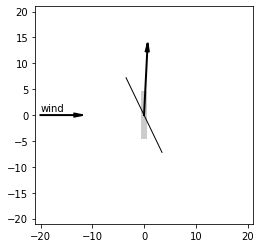

In [8]:
theta_k = 0.
theta_s = np.pi / 7.
plot_boat(vair, vwater, theta_s, theta_k)

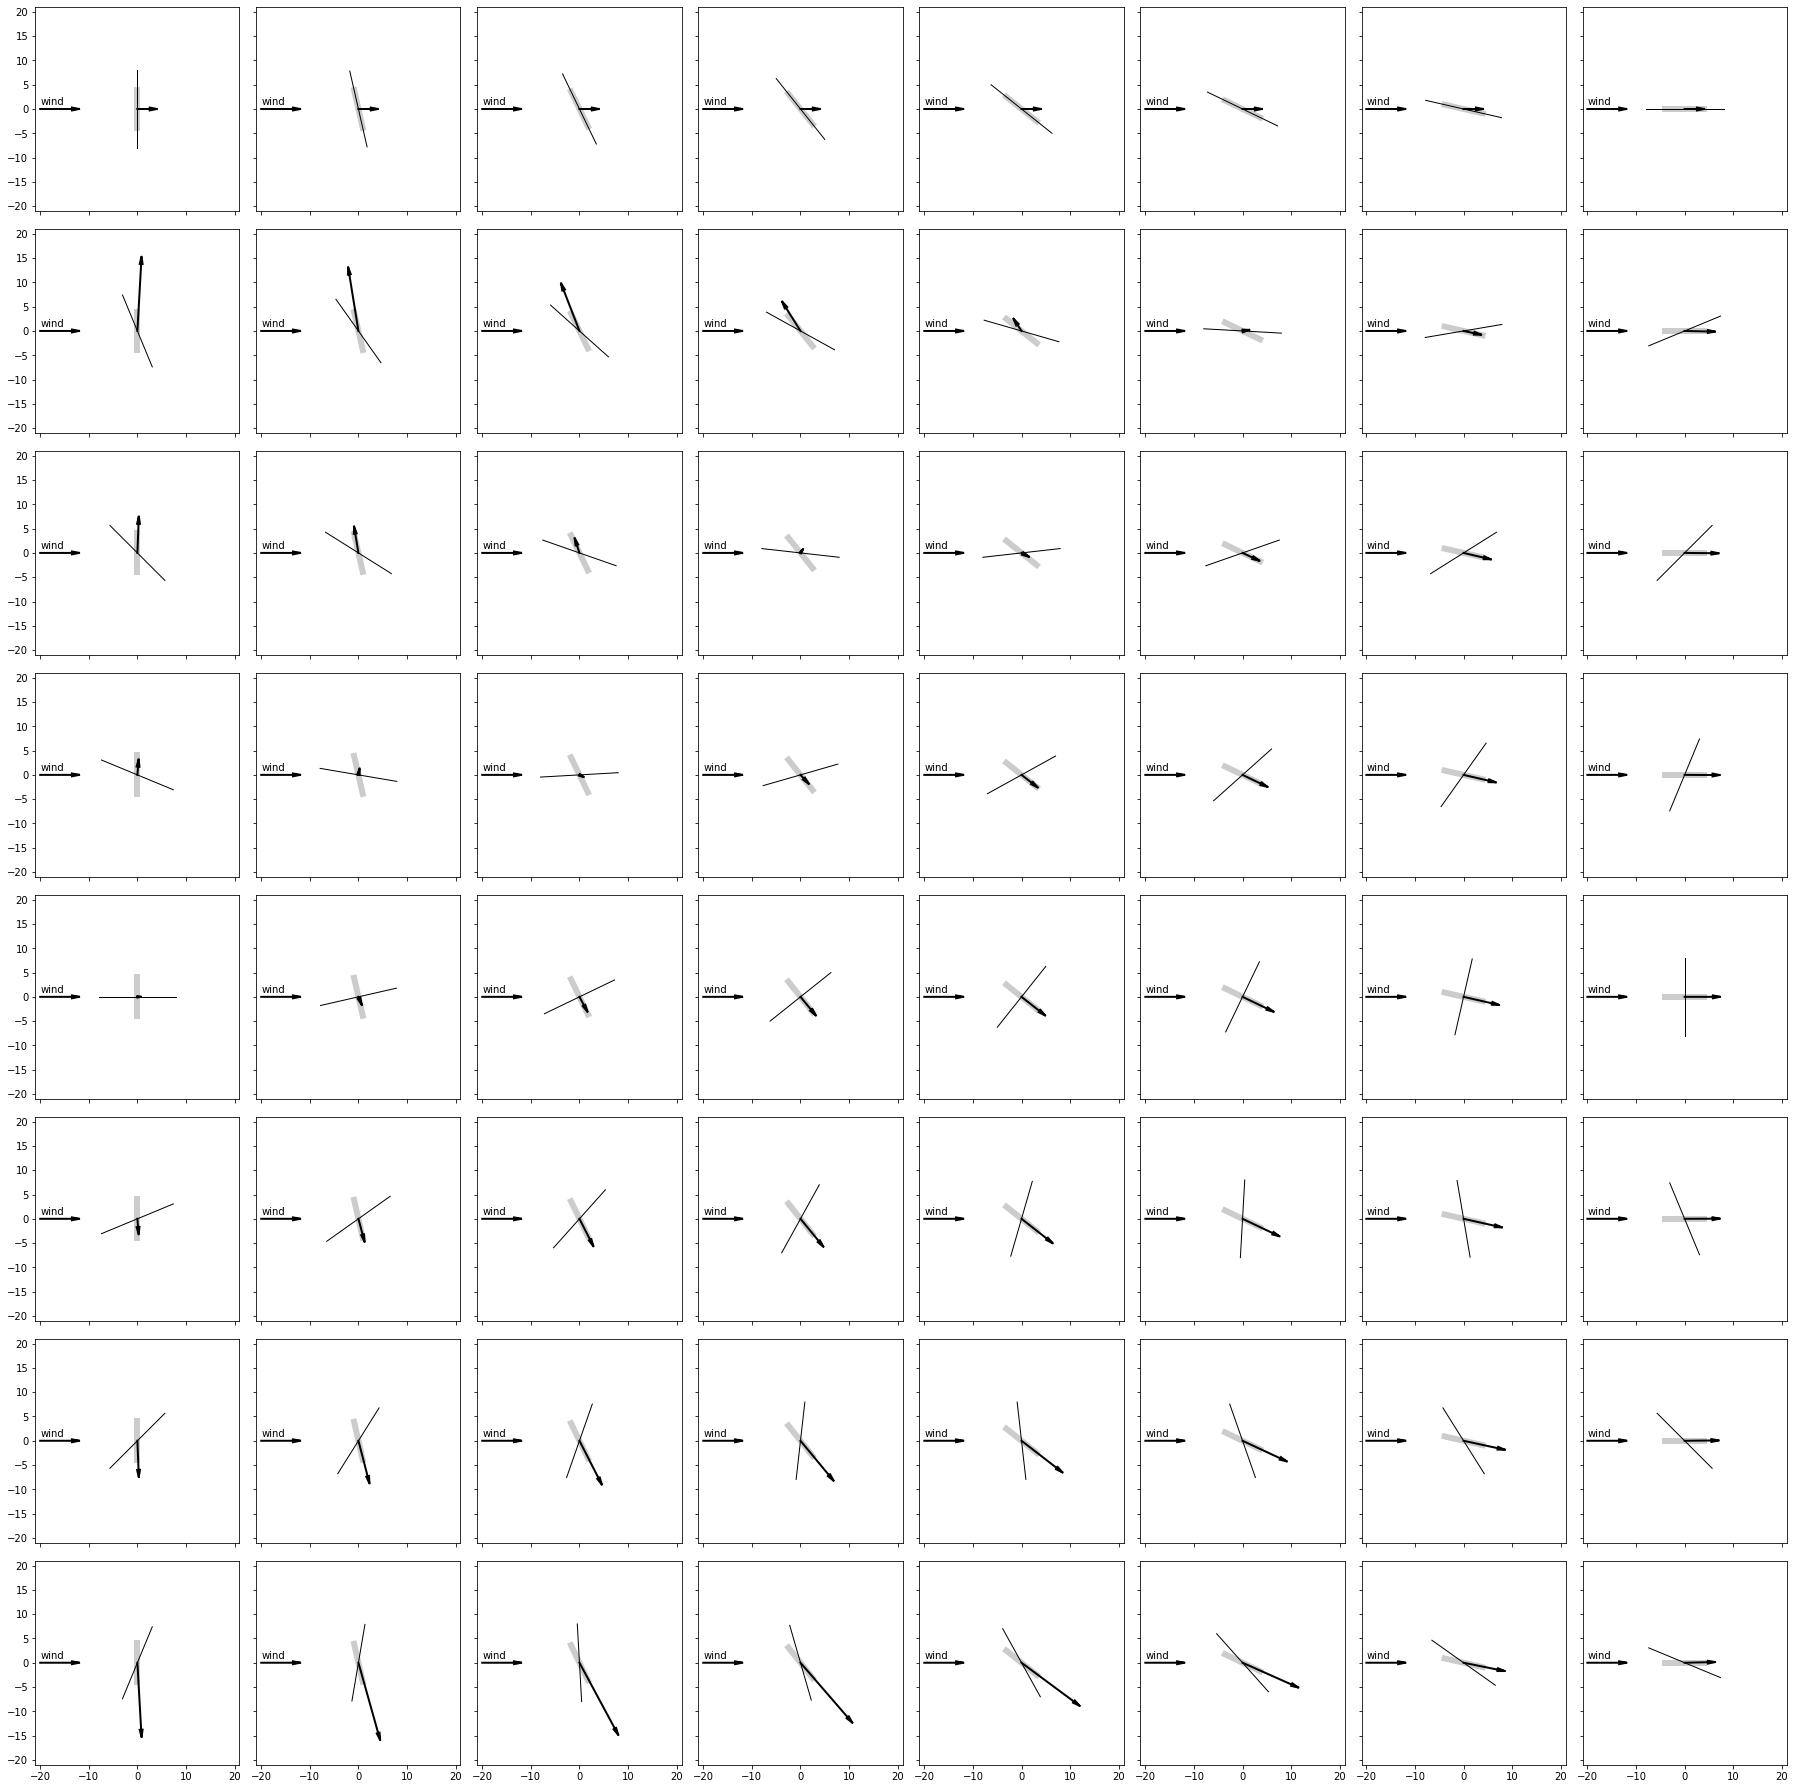

In [9]:
# a grid of cases
n1, n2 = 8, 8
fig, axes = plt.subplots(n1, n2, sharex=True, sharey=True, figsize=(25, 25), tight_layout=True)

for i in range(n1):
  for j in range(n2):
    theta_k = j * 0.5 * np.pi / (n2 - 1)
    theta_s = i * 1.0 * np.pi / n1 + np.pi + theta_k
    plot_boat(vair, vwater, theta_s, theta_k, ax=axes[i, j])

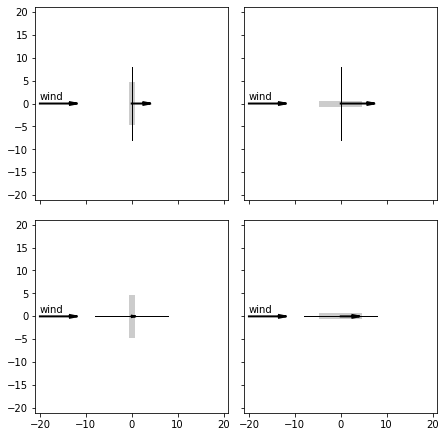

In [23]:
# a few wind-aligned cases
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6.25, 6.25), tight_layout=True)
axes = axes.flatten()
i = 0
for theta_s in (0., np.pi / 2.):
  for theta_k in (0., np.pi / 2.):
    plot_boat(vair, vwater, theta_s, theta_k, ax=axes[i])
    i += 1

In [12]:
# now do a very large number of trials:
ntrials = 3000
vavbmax, vavbmin = 0., 0.
vboats = np.zeros((ntrials, 2))
for trial in range(ntrials):
  theta_s, theta_k = 2. * np.pi * np.random.uniform(size=(2))
  vb = get_vboat(vair, vwater, theta_s, theta_k)
  vboats[trial] = vb
  if vair @ vb > vavbmax:
    vavbmax = vair @ vb
    downwind = (theta_s, theta_k)
  if vair @ vb < vavbmin:
    vavbmin = vair @ vb
    upwind = (theta_s, theta_k)

Text(0.5, 1.0, 'lots of random sail-keel settings')

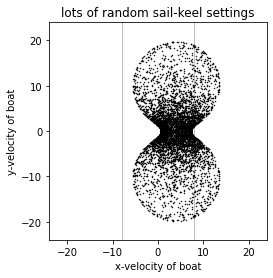

In [13]:
# HOGG: IS IT A COINCIDENCE THAT THIS LOOKS LIKE a projection of Y_10(theta, phi)?

plt.axvline(vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
plt.axvline(-vair[0], color="k", alpha=0.25, lw=1) # WARNING: BRITTLE
plt.plot(vboats[:, 0], vboats[:, 1], "k.", ms=1)
plt.plot(vboats[:, 0], -vboats[:, 1], "k.", ms=1) # WARNING: BRITTLE
plt.xlim(-24, 24)
plt.ylim(-24, 24)
plt.gca().set_aspect("equal")
plt.xlabel("x-velocity of boat")
plt.ylabel("y-velocity of boat")
plt.title("lots of random sail-keel settings")

Text(0.5, 1.0, 'best upwind tack')

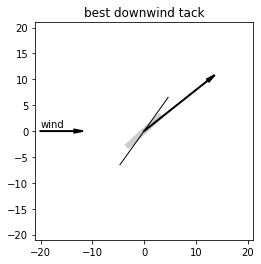

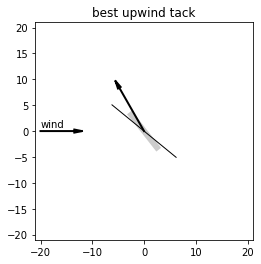

In [14]:
plot_boat(vair, vwater, *downwind)
plt.title("best downwind tack")
plt.figure()
plot_boat(vair, vwater, *upwind)
plt.title("best upwind tack")

In [15]:
# now consier best-possible boat settings, given a vector towards the destination

# HOGG WARNING: THIS CODE IS NOT CORRECT BECAUSE IT DOES LOCAL OPTIMIZATION!
# I THINK WE NEED TO GO TO INTERPOLATION OF A LOOKUP TABLE.
def get_best_thetas(r_dest, vair, vwater):
  def foo(pars):
    return -r_dest @ get_vboat(vair, vwater, *pars)
  theta_s0 = np.arctan2(r_dest[1], r_dest[0])
  theta_k0 = theta_k + 0.5 * np.pi
  res = op.minimize(foo, (theta_s0, theta_k0), method="Nelder-Mead")
  return res['x']

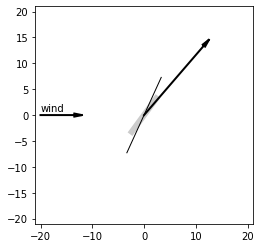

In [16]:
r_dest = np.array([2., 1.])
best = get_best_thetas(r_dest, vair, vwater)
plot_boat(vair, vwater, *best)

In [17]:
# now plot a course from A to B
# HOGG: WRONG: SEE ABOVE

def make_course(r_A, r_B, vair, vwater, dt = 0.1):
  bar = (r_B - r_A) @ (r_B - r_A)
  rr = 1. * r_A
  rrs = [rr, ]
  r_AB = r_B - rr
  while (rr - r_A) @ (r_B - r_A) < bar:
    best = get_best_thetas(r_AB, vair, vwater)
    vb = get_vboat(vair, vwater, *best)
    rr = rr + vb * dt
    r_AB = r_B - rr
    rrs.append(rr)
  return np.array(rrs)

In [18]:
rA = np.array([0., 0.])
rB = np.array([-100., 100.])
rrs = make_course(rA, rB, vair, vwater)

(203, 2)


Text(0.5, 1.0, 'this plot is wrong')

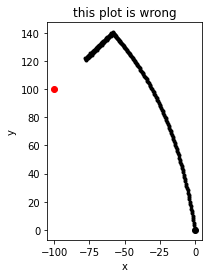

In [19]:
print(rrs.shape)
plt.plot([rA[0],], [rA[1],], "ko")
plt.plot([rB[0],], [rB[1],], "ro")
plt.plot(rrs[:,0], rrs[:,1], "k-")
plt.plot(rrs[:,0], rrs[:,1], "k.")
plt.gca().set_aspect("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.title("this plot is wrong")